# HWAI Project TODO:Code cleanup

Import section

In [1]:
import sys, os, pathlib
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers, optimizers
from keras.applications import MobileNetV2, MobileNet
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from tqdm import tqdm
from importlib import reload
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import visualkeras, logging,datetime

#suppress warnings
tf.get_logger().setLevel(logging.ERROR)

2023-05-03 15:36:30.606104: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-03 15:36:31.901700: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
IMAGESIZE = 96 #TODO: Check arduino cam size
DATADIR_train = "/home/mattiamorabito/Documents/HwAi-linux/RottenCAM.v2i.folder/train/"
DATADIR_valid = "/home/mattiamorabito/Documents/HwAi-linux/RottenCAM.v2i.folder/valid/"
DATADIR_test  = "/home/mattiamorabito/Documents/HwAi-linux/RottenCAM.v2i.folder/test/"

Check if GPU is mounted

In [3]:
device_name = tf.test.gpu_device_name()
print(device_name)
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

/device:GPU:0
Found GPU at: /device:GPU:0


2023-05-03 15:36:34.401490: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-03 15:36:34.731192: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-03 15:36:34.731610: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Loading dataset

In [4]:
#TODO: Add plots for dataset
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = tf.keras.utils.image_dataset_from_directory(
                DATADIR_train,seed = 26,
                labels='inferred',
                label_mode='categorical',
                shuffle=True,
                image_size=(IMAGESIZE, IMAGESIZE)).map(lambda x, y: (normalization_layer(x), y)).cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds   = tf.keras.utils.image_dataset_from_directory(
                DATADIR_valid,
                seed = 26,
                labels='inferred',
                label_mode='categorical',
                shuffle=True,
                image_size=(IMAGESIZE, IMAGESIZE)).map(lambda x, y: (normalization_layer(x), y)).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

Found 19629 files belonging to 8 classes.
Found 1309 files belonging to 8 classes.


2023-05-03 15:36:37.329698: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-03 15:36:37.329901: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-03 15:36:37.330042: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model instances and visualization

In [104]:
# import model definitions
from modules import models,utils
reload(models)
reload(utils)
from modules import models,utils


# Istanciate Model    
#model = models.JoJoBizzareModel(input_size=IMAGESIZE,alpha=0.25)
#model = models.JoJoBizzareModelScalable(num_classes=8,input_size=96,alpha=0.25,beta=6,channels=32,g=1.3)
#model = models.JoJoBizzareModelScalable(num_classes=8,input_size=96,alpha=1,beta=4,channels=12,g=1.6)
model = models.JoJoBizzareModelScalable_r(num_classes=8,input_size=96,alpha=1.0,beta=4,strides=3,channels=16,gain=1.0)
utils.keras_model_memory_usage(model=model,batch_size = 1)
model.summary()


╒══════╤═════════════════════════════╤════════════╤═══════════════╤════════════════════╕
│   N# │ Layer                       │ Datatype   │   Memory (KB) │ Shape              │
╞══════╪═════════════════════════════╪════════════╪═══════════════╪════════════════════╡
│    1 │ Conv0                       │ float32    │        73.728 │ (None, 32, 32, 18) │
├──────┼─────────────────────────────┼────────────┼───────────────┼────────────────────┤
│    2 │ CBlock_1_SepConv2D          │ float32    │        35.84  │ (None, 16, 16, 35) │
├──────┼─────────────────────────────┼────────────┼───────────────┼────────────────────┤
│    3 │ CBlock_1_BatchNorm          │ float32    │        35.84  │ (None, 16, 16, 35) │
├──────┼─────────────────────────────┼────────────┼───────────────┼────────────────────┤
│    4 │ CBlock_1_ReLu               │ float32    │        35.84  │ (None, 16, 16, 35) │
├──────┼─────────────────────────────┼────────────┼───────────────┼────────────────────┤
│    5 │ CBlock_2_Sep

Model Training (With QAT) [See Ex4 28/04/2023]

In [ ]:
#tflite
import tensorflow_model_optimization as tfmot

quantize_model = tfmot.quantization.keras.quantize_model

# q_aware stands for for quantization aware.
q_aware_model = quantize_model(model)

# `quantize_model` requires a recompile.
q_aware_model.compile(
        loss='categorical_crossentropy',
        optimizer=optimizers.Adam(learning_rate=0.00002),
        metrics=['accuracy']
    )

q_aware_model.summary()

Model training (Without QAT)

In [105]:
%load_ext tensorboard

#set checkpoint
checkpoint = ModelCheckpoint('savedmodels/'+str(model.name)+'.h5', save_best_only=True)
log_dir = "logs/fit/" + str(model.name) + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

#train with gpu
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        epochs=300,
        batch_size=32,
        callbacks=[
            checkpoint,
            tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True),
            tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-6),
            tensorboard_callback
            ],
        validation_data=val_ds
    )

%tensorboard --logdir logs/fit

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Epoch 1/300
614/614 [==============================] - 6s 8ms/step - loss: 2.0477 - accuracy: 0.1772 - val_loss: 2.0062 - val_accuracy: 0.2108 - lr: 1.0000e-05
Epoch 2/300
614/614 [==============================] - 4s 7ms/step - loss: 1.9221 - accuracy: 0.2505 - val_loss: 1.8577 - val_accuracy: 0.2827 - lr: 1.0000e-05
Epoch 3/300
614/614 [==============================] - 4s 7ms/step - loss: 1.8377 - accuracy: 0.2934 - val_loss: 1.7747 - val_accuracy: 0.3102 - lr: 1.0000e-05
Epoch 4/300
614/614 [==============================] - 4s 7ms/step - loss: 1.7731 - accuracy: 0.3238 - val_loss: 1.7105 - val_accuracy: 0.3361 - lr: 1.0000e-05
Epoch 5/300
614/614 [==============================] - 4s 7ms/step - loss: 1.7209 - accuracy: 0.3486 - val_loss: 1.6599 - val_accuracy: 0.3636 - lr: 1.0000e-05
Epoch 6/300
614/614 [==============================] - 4s 7ms/step - loss: 1.6779 - accuracy: 0.3691 - val_los

Evaluate performance of FLOAT32 Model

Evaluate
Found 874 files belonging to 8 classes.


  0%|          | 0/44 [00:00<?, ?it/s]2023-05-03 19:11:57.880294: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [874]
	 [[{{node Placeholder/_0}}]]
2023-05-03 19:11:57.880736: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [874]
	 [[{{node Placeholder/_0}}]]
100%|██████████| 44/44 [00:02<00:00, 17.47it/s]


0.8409610983981693


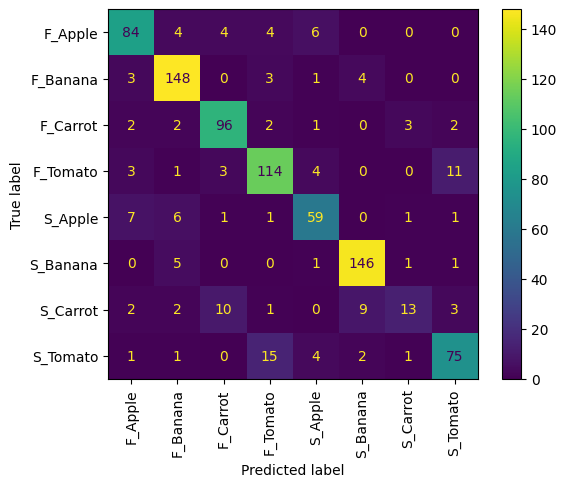

In [79]:
print("Evaluate")
#load test dataset
test_dataset = tf.keras.utils.image_dataset_from_directory(
                              DATADIR_test,
                              labels='inferred',
                              batch_size=20,
                              label_mode='categorical',
                              image_size=(IMAGESIZE, IMAGESIZE))

#extract class names
classes = test_dataset.class_names
#rescale
test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), y))

#TODO: move to utils
#get predictions
predictions = np.array([])
labels =  np.array([])
for x, y in tqdm(test_dataset):
  # selecet the class for which i have the max confidence
  predictions = np.concatenate([predictions, np.argmax(model.predict(x,verbose=0), axis = -1)])
  labels = np.concatenate([labels, np.argmax(y.numpy(), axis=-1)])

print(accuracy_score(labels, predictions))
t = confusion_matrix(labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=t,display_labels=classes)
disp.plot(xticks_rotation='vertical')
plt.show()


Save model and convert to TFlite

In [80]:
MODEL_NAME = "/home/mattiamorabito/Documents/HwAi-linux/savedmodels/"+str(model.name)
tf.saved_model.save(model, MODEL_NAME)

converter = tf.lite.TFLiteConverter.from_saved_model(MODEL_NAME)
converter.optimizations = [tf.lite.Optimize.DEFAULT]


def representative_data_gen():                          # Uncomment the following 5 lines for Model 3
    for input_value, _ in test_dataset.take(20):
        yield [input_value]
converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
#converter.inference_input_type = tf.uint8
#converter.inference_output_type = tf.uint8

tflite_model = converter.convert()
tflite_models_dir = "/home/mattiamorabito/Documents/HwAi-linux/tflite/"

tflite_model_file = pathlib.Path(tflite_models_dir+model.name+'.tflite')
tflite_model_file.write_bytes(tflite_model)

2023-05-03 19:12:21.897177: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,24]
	 [[{{node inputs}}]]
2023-05-03 19:12:22.668669: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,24]
	 [[{{node inputs}}]]
2023-05-03 19:12:24.150462: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-05-03 19:12:24.150502: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2023-05-03 19:12:24.151867: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel

52448

Test quantized model

In [81]:
#tflite_models_dir = pathlib.Path("/home/mattiamorabito/Documents/HwAi-linux/tflite/")
#tflite_model_file = tflite_models_dir/'jojo_noINT.tflite'
interpreter = tf.lite.Interpreter(model_path=str(tflite_model_file))
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

predictions = []

test_ds = tf.keras.utils.image_dataset_from_directory(DATADIR_test,labels='inferred',batch_size=1,label_mode='categorical',image_size=(IMAGESIZE, IMAGESIZE))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

test_labels, test_imgs = [], []
for img, label in tqdm(test_ds):
    interpreter.set_tensor(input_index, img)
    interpreter.invoke()
    predictions.append(interpreter.get_tensor(output_index))
    test_labels.append(label.numpy()[0])
    test_imgs.append(img)


score = 0
for item in range(0,len(predictions)):
  prediction=np.argmax(predictions[item])
  label = np.argmax(test_labels[item])
  if prediction==label:
    score=score+1
print("| Out of 874 predictions I got " + str(score) + " correct | Accuracy: "+ str(score/len(predictions)*100) + "% |")

Found 874 files belonging to 8 classes.


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
  0%|          | 0/874 [00:00<?, ?it/s]2023-05-03 19:12:37.340792: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [874]
	 [[{{node Placeholder/_4}}]]
2023-05-03 19:12:37.341120: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [874]
	 [[{{node Placeholder/_0}}]]
100%|██████████| 874/874 [00:00<00:00, 1886.22it/s]

| Out of 874 predictions I got 741 correct | Accuracy: 84.78260869565217% |


See model structure and history

Model: "jojo_sr_n8_r96_a1_b4_g1.0"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv0 (Conv2D)              (None, 48, 48, 16)        448       
                                                                 
 CBlock_1_SepConv2D (Separab  (None, 24, 24, 32)       688       
 leConv2D)                                                       
                                                                 
 CBlock_1_BatchNorm (BatchNo  (None, 24, 24, 32)       128       
 rmalization)                                                    
                                                                 
 CBlock_1_ReLu (Activation)  (None, 24, 24, 32)        0         
                                                                 
 CBlock_2_SepConv2D (Separab  (None, 12, 12, 64)       2400      
 leConv2D)                                                       
                                         

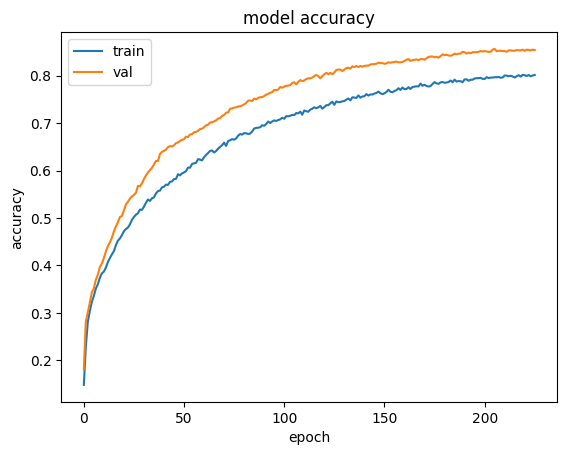

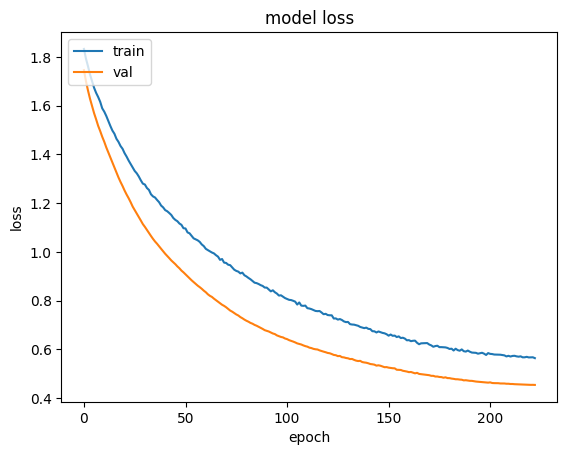

In [82]:
# see model structure
visualkeras.layered_view(model,legend=True).show() # display using your system viewer
model.summary()

# model training history
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'][3:])
plt.plot(history.history['val_loss'][3:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Weight distrubution

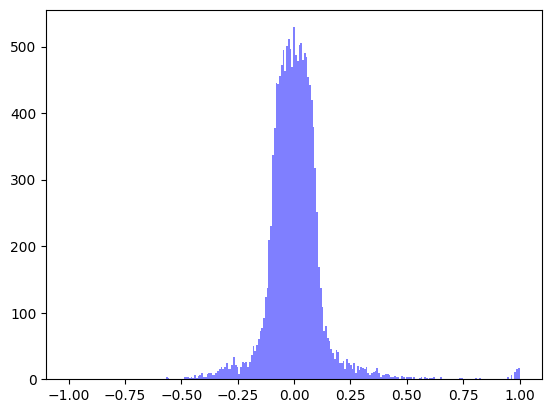

In [18]:
all_wi = []
wi = model.weights
for elem in wi:
  var = list(elem.read_value().numpy().flatten())
  all_wi= all_wi +var
s = np.array(all_wi)
sbins = np.linspace(-1,1,256)
plt.hist(s, bins=sbins, facecolor='blue', alpha=0.5)
plt.show()